In [ ]:
import torch
import pandas as pd
import seaborn as sns
from mlm import *
import matplotlib.pyplot as plt

/home/jsun/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


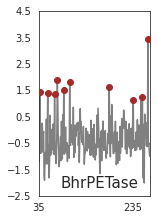

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

model = torch.load('./models/PF01083_19.pt', map_location=device)

model.eval()

def read_vocab(vocab_file):
    vocab_dict = {}
    with open(vocab_file, 'r') as vocab_file:
        for i, line in enumerate(vocab_file):
            vocab = line.replace("\n", "")
            vocab_dict[vocab] = i
    return vocab_dict

vocab = read_vocab('vocab.txt')

def tokenizer(seq):
    x = torch.zeros(len(seq)+2)
    x[0] = 2
    for i, aa in enumerate(seq):
        w = vocab.get(aa)
        if w:
            x[i+1] = w
        else:
            x[i+1] = 1
    x[-1] = 3
    return x.long()

def check_heatmap():
    raw_sequence = "SNPYQRGPNPTRSALTTDGPFSVATYSVSRLSVSGFGGGVIYYPTGTTLTFGGIAMSPGYTADASSLAWLGRRLASHGFVVIVINTNSRLDFPDSRASQLSAALNYLRTSSPSAVRARLDANRLAVAGHSMGGGATLRISEQIPTLKAGVPLTPWHTDKTFNTPVPQLIVGAEADTVAPVSQHAIPFYQNLPSTTPKVYVELDNATHFAPNSPNAAISVYTISWMKLWVDNDTRYRQFLCNVNDPALSDFRSNNRHCQ"

    inp = tokenizer(raw_sequence).view(1, -1)
    map = []
    for i, w in enumerate(raw_sequence):
        wild = vocab[w]
        inp[0][i] = 4
        with torch.no_grad():
            y = model(inp.to(device))
            map.append(list(y[0].cpu()[i].numpy() - y[0].cpu()[i].numpy()[wild])[5:])
        inp = tokenizer(raw_sequence).view(1, -1)
    return map

map = check_heatmap()

plot_x = []
plot_y = []

for x, y in zip([i for i in range(len(map))], np.array(map).mean(axis=-1)):
    if x+36 < 280: # we remove the unstructured C-terminal
        plot_x.append(x+36)
        plot_y.append(y)

df = pd.DataFrame({'pos':plot_x, 'score':plot_y})
top10 = df.sort_values('score', ascending=False).head(10)

sns.set_style('white')
fig, ax = plt.subplots(figsize=(2,3.4))
sns.lineplot(x=(np.array(plot_x)-36)/(len(plot_x)), y=plot_y, color='grey')
ax.set_xlim([0,1])
ax.set_ylim([-2.5,4.5])
ax.set_yticks(np.arange(8)-2.5)
ax.set_xticks([0,235/max(plot_x)])
ax.set_xticklabels([35, 235])
ax.scatter(x=(top10['pos']-36)/len(plot_x), y=top10['score'], color='brown', zorder=10)
ax.text(x=0.2,y=-2.2,s='BhrPETase', fontsize=15)
plt.show()
